In [126]:
import os
import re
import math
import gzip
import urllib
import string
import tarfile
import requests
import collections
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from datetime import datetime
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import seaborn as sns
import networkx as nx
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
%matplotlib inline

In [127]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [128]:
cmu_path = "data/MovieSummaries/"
corenlp_path = "data/CoreNLP/"
summary_raw_path = corenlp_path+"corenlp_plot_summaries/"
summary_path = corenlp_path+"corenlp_plot_summaries_xml/"
movies_path = cmu_path+"movie.metadata.tsv"
characters_path = cmu_path+"character.metadata.tsv"
plot_path = cmu_path+"plot_summaries.txt"

In [129]:
if not os.path.exists(movies_path):
    movie_url = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    tar_file = tarfile.open(fileobj=urllib.request.urlopen(movie_url), mode="r:gz") 
    tar_file.extractall(path=movies_path)
    tar_file.close()

In [130]:
# if not os.path.exists(corenlp_path):
#     corenlp_url = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
#     tar_file = tarfile.open(fileobj=urllib.request.urlopen(corenlp_url), mode="r|") 
#     tar_file.extractall(path=corenlp_path)
    
#     os.mkdir(summary_path)
#     for filename in os.listdir(summary_raw_path):
#         f = os.path.join(summary_raw_path, filename) 
#         if os.path.isfile(f):
#             with gzip.open(f, 'rb') as f_in:
#                 gz_file = os.path.join(summary_path, filename)
#                 with open(gz_file[:-3], 'wb') as f_out:
#                     f_out.write(f_in.read())
#     tar_file.close()

In [131]:
movies_column_names = [
    "wikipedia_id",
    "freebase_id",
    "name",
    "release_date",
    "box_office_revenue",
    "runtime",
    "languages",
    "countries",
    "genres"
]

characters_column_names = [
    "wikipedia_id",
    "freebase_id",
    "release_date",
    "character_name",
    "actor_dob",
    "actor_gender",
    "actor_height",
    "actor_ethnicity",
    "actor_name",
    "actor_age",
    "freebase_character_map",
    "freebase_character_id",
    "freebase_actor_id"
]

plot_column_names = ['wikipedia_id', 'summary']

movies = pd.read_csv(movies_path, sep='\t', header=None, names=movies_column_names)
characters = pd.read_csv(characters_path, sep='\t', header=None, names=characters_column_names)
plots = pd.read_csv(plot_path, sep='\t', header=None, names=plot_column_names)

In [132]:
movies.head()

,wikipedia_id,freebase_id,name,release_date,box_office_revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [133]:
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [134]:
characters.shape

(450669, 13)

In [135]:
movies.shape

(81741, 9)

## Questions:
  Is there any difference on actors' career by genders?

  divide this into 2 sub questions:
  1. Do f/m have equal opportunities as actors? 
    a. Population proportion different?
    b. Age distribution different?  does female have fewer chance when they get older than males? if so, what is the factor?
  2. Do they tend to enjoy similar level of career success? 
      - metric of success: revenue their movies have earned, the social influence of them , the importance of their characters (e.g. by proportion of descriptions in the plot summary.)
      - ... 

### year-grouped analysis

In [136]:
def extract_year(x):
    return str(x)[:4]

In [137]:
characters['movie_year'] = characters['release_date'].apply(extract_year)
characters.head()

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001


In [138]:
tmp_years = sorted(characters.movie_year.unique())
print(tmp_years[:5], tmp_years[-5:])

['1010', '1888', '1891', '1893', '1894'] ['2013', '2014', '2015', '2016', 'nan']


There is 2 sets of abnormal year data in the dataset:

1. some has <nan> year data, here we just drop them.
2. one movie was release in 2010, but it was mistakenly written as 1010, we correct this.

In [139]:
characters[characters['movie_year']=='nan']

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
337,27374355,/m/0by1_ff,NaN,NaN,1953-03-16,F,1.60,NaN,Isabelle Huppert,NaN,/m/0bykcy4,NaN,/m/012g92,nan
494,10792038,/m/02qq3mb,NaN,NaN,1950-12-12,M,1.75,/m/0cqgdq,Rajnikanth,NaN,/m/03kxr5d,NaN,/m/02wmbg,nan
519,11717027,/m/02rpz18,NaN,NaN,1908-05-30,M,NaN,/m/041rx,Mel Blanc,NaN,/m/052c_g2,NaN,/m/0c5vh,nan
520,10628777,/m/02qkn7c,NaN,NaN,1964-01-15,F,1.69,NaN,Bhanupriya,NaN,/m/0jmx_q5,NaN,/m/08mdtm,nan
521,10628777,/m/02qkn7c,NaN,NaN,1972-07-18,F,NaN,NaN,Soundarya,NaN,/m/0jmx290,NaN,/m/02vd_b,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450334,29119097,/m/0dlmtgr,NaN,NaN,NaN,M,NaN,NaN,Biswajit Chakraborty,NaN,/m/0hhz7cc,NaN,/m/0dgsd62,nan
450494,17198681,/m/043mrjw,NaN,NaN,1970-03-23,F,NaN,NaN,Melissa Errico,NaN,/m/0cmxspd,NaN,/m/0269llv,nan
450495,17198681,/m/043mrjw,NaN,Barbie Loving Bartender,1965-09-03,M,1.75,/m/042gtr,Charlie Sheen,NaN,/m/04fz126,/m/04fz129,/m/01pllx,nan
450496,17198681,/m/043mrjw,NaN,Make-up Lady,1967-04-02,F,NaN,/m/042gtr,Renée Estevez,NaN,/m/0h5mg_5,/m/0h5mg_7,/m/0331rx,nan


In [140]:
characters[characters['movie_year']=='1010']

,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
67624,29666067,/m/0fphzrf,1010-12-02,Kamuran,1983,M,NaN,NaN,Bartu Küçükçaglayan,NaN,/m/0n4fxh5,/m/0n4fxh8,/m/0df0qkt,1010
67625,29666067,/m/0fphzrf,1010-12-02,Ferman,1941-12-26,M,NaN,NaN,Şener Şen,NaN,/m/0gb33kh,/m/0n4fgzm,/m/02z247j,1010
67626,29666067,/m/0fphzrf,1010-12-02,Idris,1973-04-23,M,NaN,NaN,Cem Yılmaz,NaN,/m/0gb33kn,/m/0n4flr2,/m/0fz9xn,1010
67627,29666067,/m/0fphzrf,1010-12-02,Hasan,1978-12-13,M,NaN,NaN,Okan Yalabık,NaN,/m/0ggd8h0,/m/0n4fsc3,/m/0cmb83k,1010
67628,29666067,/m/0fphzrf,1010-12-02,Battal,1945-07-16,M,NaN,NaN,Çetin Tekindor,NaN,/m/0h9dtmf,/m/0n4frvc,/m/0ch5v5f,1010
67629,29666067,/m/0fphzrf,1010-12-02,Asiye,1985-07-06,F,NaN,NaN,Melisa Sözen,NaN,/m/0k3m4yc,/m/0n4fs00,/m/0ch3v_t,1010
67630,29666067,/m/0fphzrf,1010-12-02,Asit Omer,NaN,M,NaN,NaN,Riza Kocaoglu,NaN,/m/0n4fssj,/m/0n4fssm,/m/0n4fssv,1010
67631,29666067,/m/0fphzrf,1010-12-02,Hatun,NaN,F,NaN,NaN,Nergis Çorakçi,NaN,/m/0n4ftj1,/m/0n4ftj4,/m/0n4ftjc,1010
67632,29666067,/m/0fphzrf,1010-12-02,Müslüm,1963,M,NaN,NaN,Mustafa Avkiran,NaN,/m/0n4fv9p,/m/0n4fv9s,/m/0gc9xb7,1010
67633,29666067,/m/0fphzrf,1010-12-02,Murat Önes,NaN,M,NaN,NaN,Mahir Ipek,NaN,/m/0n4fvtw,/m/0n4fvtz,/m/0n4fvv5,1010


In [141]:
characters.loc[characters['movie_year']=='1010','movie_year']='2010'

In [142]:
characters_with_year = characters[characters['movie_year']!='nan']

characters_with_year['movie_year'] = characters_with_year['movie_year'].apply(lambda x: int(x))
print(characters_with_year.shape)
characters_with_year.head()

(440674, 14)


/var/folders/kc/568hl5mn7tv3f90kll8cmsrr0000gn/T/ipykernel_25381/99160358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_with_year['movie_year'] = characters_with_year['movie_year'].apply(lambda x: int(x))


,wikipedia_id,freebase_id,release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id,movie_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,2001
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,2001
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,2001
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,2001


## Actor age evolution for genders

In [143]:
female = characters_with_year[characters_with_year['actor_gender']=='F']
male = characters_with_year[characters_with_year['actor_gender']=='M']

female_age = female[female['actor_age']>=0][['actor_age','movie_year']]
male_age = male[male['actor_age']>=0][['actor_age','movie_year']]

female_age.head()

,actor_age,movie_year
0,42.0,2001
1,27.0,2001
4,23.0,2001
5,52.0,2001
6,56.0,2001


In [144]:
print(female_age[female_age['movie_year']<1920].shape)
print(male_age[male_age['movie_year']<1920].shape)

(110, 2)
(36, 2)


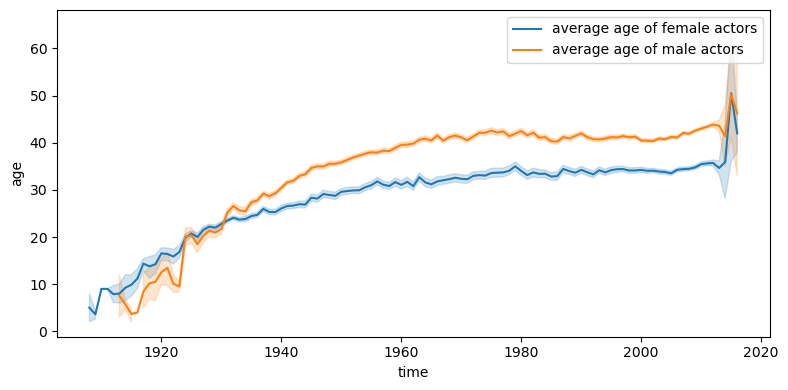

In [145]:
plt.figure(figsize=(8,4))

ax = sns.lineplot(
    data = female_age, x = "movie_year", y = 'actor_age',
    legend = "full", label = "average age of female actors"

    )
ax = sns.lineplot(
    data = male_age, x = "movie_year", y = 'actor_age' ,
    legend = "full", label = "average age of male actors"
    )
plt.xlabel("time")
plt.ylabel("age")
plt.tight_layout()
plt.show()

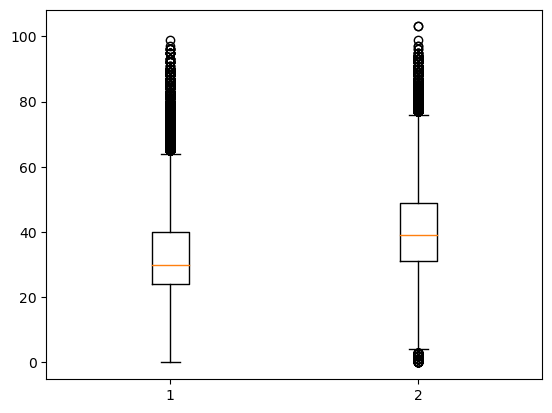

In [146]:
age_dis = [female_age['actor_age'].values, male_age['actor_age'].values]
plt.boxplot(age_dis)
plt.show()


In [147]:
stats.ttest_ind(female_age['actor_age'], male_age['actor_age'])

Ttest_indResult(statistic=-140.92509242040052, pvalue=0.0)

### Analysis
1. ttest p value equals zero, which means mean value of the two distribution are totally different
2. The lineplots also show the average age actors through years. Female actors are generally younger than male actors when they play actors in movies since 1935s. From 1925s to 1935s, average age is roughly same. From 1915s to 1925s, female actors are younger. For previous years, the total actor counts of whom are notated with yearsare less than 50, it is too small a dataset size to draw some feasible conclustions. Why is this happenning?
3. The lineplots also shows an ascending trend in age of both female and male actors, but with different time periods and gradually become flat in recent years. Why does this happen?

## Gender difference on character population

In [148]:
female_year_grouped = female.groupby(by='movie_year')
male_year_grouped= male.groupby(by='movie_year')

In [149]:
female_years = pd.DataFrame(columns=['nums'])
female_years['nums'] = female_year_grouped.size()
male_years = pd.DataFrame(columns=['nums'])
male_years['nums'] = male_year_grouped.size()


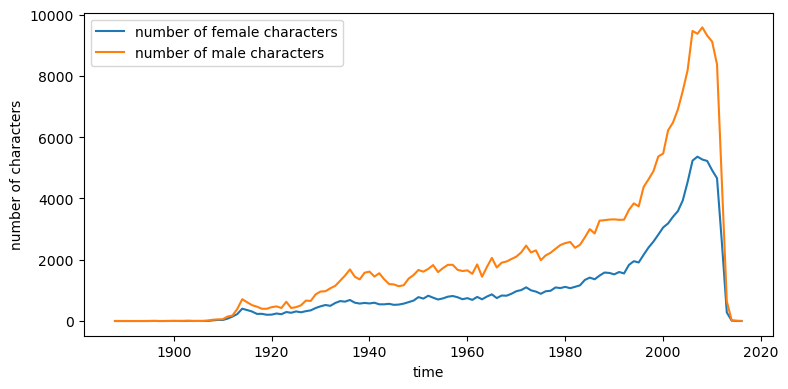

In [150]:
plt.figure(figsize=(8,4))


ax = sns.lineplot(data = female_years, x = "movie_year", y = "nums", legend = "full", label = "number of female characters")
ax = sns.lineplot(data = male_years, x = "movie_year", y = "nums", legend = "full", label = "number of male characters")


plt.xlabel("time")
plt.ylabel("number of characters")
plt.tight_layout()
plt.show()

126 121


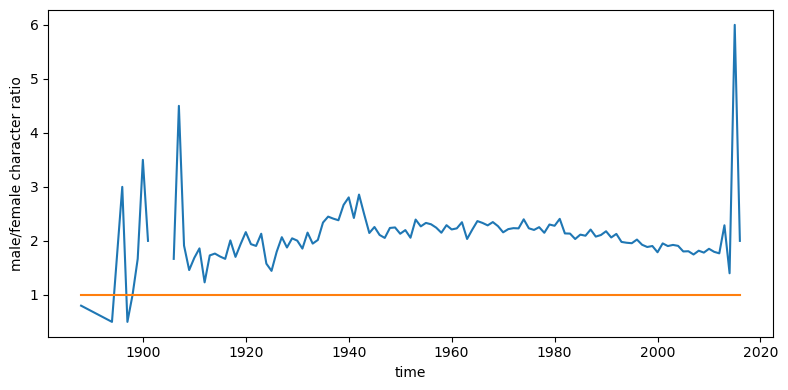

In [151]:
plt.figure(figsize=(8,4))

ratio = male_years / female_years
print(len(male_years), len(female_years))

# since female_years is shorter
length = len(female_years)
plt.plot(female_years.index, ratio[-length:])
plt.plot(female_years.index, np.ones(len(female_years)))

plt.xlabel("time")
plt.ylabel("male/female character ratio")

plt.tight_layout()
plt.show()

In [152]:
print([idx if idx not in female_years.index else '' for idx in male_years.index ])


['', 1891, 1893, '', 1895, '', '', '', '', '', '', '', '', 1904, 1905, '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']


### Analysis
Male characters are always more than female characters, showing insufficient opportunities of female actresses. Why?
Possible reasons:
1. Gender proportion of one movie is highly affected by its genre. Maybe "male movies" like war movies are preferred by the market.
2. Stereotype influence are so strong that people seldom break the existing personas given to women.
3. Social influence: when people tend to cooperate with whom they have already been familiar with, the existing relationship with male actors give them more chance.

## Future work:

To confirm the reasons to the first question: 